In [15]:
%matplotlib inline

In [8]:
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pickle

In [ ]:
class CallCentreMDP:
    def __init__(self, 
                 arrival_rates=(15/60, 10/60),   # Arrival rates for simple and complex queries
                 service_rates=((30/60, 10/60),  # Service rates for agent 1 (simple, complex)
                               (15/60, 14/60)),  # Service rates for agent 2 (simple, complex)
                 max_queue_size=20,           # Maximum number of customers in each queue
                 discount_factor=0.95,       # Discount factor for future rewards
                 time_horizon=1000):          # Time horizon for simulation
        
        # System parameters
        self.arrival_rates = arrival_rates  # λ1 (simple), λ2 (complex)
        self.service_rates = service_rates  # μ11, μ12, μ21, μ22
        self.max_queue_size = max_queue_size
        self.discount_factor = discount_factor
        self.time_horizon = time_horizon
        
        # State space: (queue1_size, queue2_size, incoming_call_type)
        # where incoming_call_type: 0 for simple, 1 for complex
        self.state_space = []
        for q1 in range(max_queue_size + 1):
            for q2 in range(max_queue_size + 1):
                for call_type in range(3):  # 0: simple, 1: complex
                    self.state_space.append((q1, q2, call_type))
        
        # Action space: 0 (route to agent 1), 1 (route to agent 2)
        self.action_space = [0, 1]
        
        # Value function and policy
        self.value_function = {state: 0 for state in self.state_space}
        self.policy = {state: 0 for state in self.state_space}
        
        # Probability of new call arrivals in a time step
        self.p_simple = arrival_rates[0] / (arrival_rates[0] + arrival_rates[1] + 1)  # Normalized probability
        self.p_complex = arrival_rates[1] / (arrival_rates[0] + arrival_rates[1] + 1)
        
        # print(f"Probabilities of call types: Simple: {self.p_simple}, Complex: {self.p_complex}, No Call: {self.p_no_call}")
        
        # Queue composition tracking - proportion of simple vs complex calls
        # Initialize with expected proportions based on arrival rates
        total_arrival_rate = sum(arrival_rates)
        self.p_type1_q1 = self.p_type1_q2 = arrival_rates[0] / total_arrival_rate  # Proportion of simple calls
        self.p_type2_q1 = self.p_type2_q2 = arrival_rates[1] / total_arrival_rate  # Proportion of complex callsS
    
    def expected_service_time(self, agent_idx, p_type1, p_type2):
        """
        Calculate expected service time for an agent based on call type proportions
        
        Args:
            agent_idx: Index of the agent (0 or 1)
            p_type1: Proportion of simple calls in the queue
            p_type2: Proportion of complex calls in the queue
            
        Returns:
            Expected service time
        """
        return p_type1 * (1.0 / self.service_rates[agent_idx][0]) + p_type2 * (1.0 / self.service_rates[agent_idx][1])
    
    def expected_waiting_time(self, queue_size, agent_idx, p_type1, p_type2, call_type):
        """
        Calculate expected waiting time for a new call in a queue
        Using the formula: E[W] = ((q + 1) / 2) * E[S]
        
        Args:
            queue_size: Number of calls in the queue
            agent_idx: Index of the agent (0 or 1)
            p_type1: Proportion of simple calls in the queue
            p_type2: Proportion of complex calls in the queue
            call_type: Type of the new call (0 for simple, 1 for complex)
            
        Returns:
            Expected waiting time
        """
        # Calculate expected service time for calls already in queue
        E_S = self.expected_service_time(agent_idx, p_type1, p_type2)
        
        # Calculate expected waiting time using the formula E[W] = ((q + 1) / 2) * E[S]
        # This formula assumes a queue with existing calls plus the new call
        expected_waiting = ((queue_size + 1) / 2) * E_S
        
        return expected_waiting
    
    def reward(self, state, action):
        """
        Calculate immediate reward (negative waiting time) for a state-action pair
        
        Args:
            state: Current state (queue1_size, queue2_size, incoming_call_type)
            action: Action to take (0: route to agent 1, 1: route to agent 2, 2: reject)
            
        Returns:
            Negative expected waiting time (reward/cost)
        """
        q1_size, q2_size, call_type = state
        
        # If no incoming call, reward is 0
        if call_type == 2:
            return 0
        
        # If action is to reject, penalty based on call type
        if action == 2:
            return -100  # High penalty for rejecting a call
        
        # If queue is full, can't route to that queue
        if action == 0 and q1_size >= self.max_queue_size:
            return -100
        if action == 1 and q2_size >= self.max_queue_size:
            return -100
        
        # Calculate expected waiting time
        if action == 0:  # Route to agent 1
            # Update proportion of call types in queue 1 if adding this call
            if q1_size == 0:
                # If queue was empty, new call determines the type distribution
                p_type1 = 1.0 if call_type == 0 else 0.0
                p_type2 = 1.0 if call_type == 1 else 0.0
            else:
                # Otherwise, update the proportions based on existing queue and new call
                p_type1 = (self.p_type1_q1 * q1_size + (1 if call_type == 0 else 0)) / (q1_size + 1)
                p_type2 = (self.p_type2_q1 * q1_size + (1 if call_type == 1 else 0)) / (q1_size + 1)
            
            waiting_time = self.expected_waiting_time(q1_size, 0, p_type1, p_type2, call_type)
            return -waiting_time  # Negative because it's a cost
            
        else:  # Route to agent 2
            # Update proportion of call types in queue 2 if adding this call
            if q2_size == 0:
                # If queue was empty, new call determines the type distribution
                p_type1 = 1.0 if call_type == 0 else 0.0
                p_type2 = 1.0 if call_type == 1 else 0.0
            else:
                # Otherwise, update the proportions based on existing queue and new call
                p_type1 = (self.p_type1_q2 * q2_size + (1 if call_type == 0 else 0)) / (q2_size + 1)
                p_type2 = (self.p_type2_q2 * q2_size + (1 if call_type == 1 else 0)) / (q2_size + 1)
            
            waiting_time = self.expected_waiting_time(q2_size, 1, p_type1, p_type2, call_type)
            return -waiting_time  # Negative because it's a cost
    
    def transition_probability(self, state, action, next_state):
        """
        Calculate transition probability from state to next_state given action
        
        Args:
            state: Current state (queue1_size, queue2_size, incoming_call_type)
            action: Action taken (0: route to agent 1, 1: route to agent 2, 2: reject)
            next_state: Next state
            
        Returns:
            Transition probability
        """
        q1_size, q2_size, call_type = state
        next_q1_size, next_q2_size, next_call_type = next_state
        
        # Handle current call based on action
        expected_q1_size, expected_q2_size = q1_size, q2_size
        
        if call_type != 2:  # If there's an incoming call
            if action == 0:  # Route to agent 1
                if q1_size >= self.max_queue_size:  # Queue 1 is full
                    return 0
                expected_q1_size = q1_size + 1
            elif action == 1:  # Route to agent 2
                if q2_size >= self.max_queue_size:  # Queue 2 is full
                    return 0
                expected_q2_size = q2_size + 1
        
        # Check if the next state's queue sizes match what we expect
        if expected_q1_size != next_q1_size or expected_q2_size != next_q2_size:
            return 0
        
        # Probability of next call type
        if next_call_type == 0:  # Simple call
            return self.p_simple
        elif next_call_type == 1:  # Complex call
            return self.p_complex
        else:  # No call
            return self.p_no_call
    
    def get_next_states_and_probs(self, state, action):
        """
        Get all possible next states and their transition probabilities
        
        Args:
            state: Current state (queue1_size, queue2_size, incoming_call_type)
            action: Action to take
            
        Returns:
            List of (next_state, probability) tuples
        """
        q1_size, q2_size, call_type = state
        next_states_and_probs = []
        
        # Determine the next queue sizes based on action
        next_q1_size, next_q2_size = q1_size, q2_size
        
        if call_type != 2:  # If there's an incoming call
            if action == 0 and q1_size < self.max_queue_size:  # Route to agent 1
                next_q1_size = q1_size + 1
            elif action == 1 and q2_size < self.max_queue_size:  # Route to agent 2
                next_q2_size = q2_size + 1
        
        # For each possible next call type
        for next_call_type in range(3):
            next_state = (next_q1_size, next_q2_size, next_call_type)
            prob = self.transition_probability(state, action, next_state)
            if prob > 0:
                next_states_and_probs.append((next_state, prob))
        
        return next_states_and_probs
    
    def value_iteration(self, max_iterations=1000, tolerance=1e-6):
        """
        Solve the MDP using value iteration algorithm
        
        Args:
            max_iterations: Maximum number of iterations
            tolerance: Convergence tolerance
            
        Returns:
            Optimal value function and policy
        """
        # Initialize value function
        V = {state: 0 for state in self.state_space}
        
        for iteration in tqdm(range(max_iterations), desc="Value Iteration"):
            delta = 0
            V_new = V.copy()
            
            for state in self.state_space:
                # If no incoming call, only consider the next call arrival
                if state[2] == 2:
                    # Get possible next states and their probabilities
                    next_states_and_probs = self.get_next_states_and_probs(state, 0)  # Action doesn't matter for no-call states
                    
                    # Calculate expected value of next states
                    expected_value = sum(prob * V[next_state] for next_state, prob in next_states_and_probs)
                    V_new[state] = expected_value
                    continue
                
                # For states with incoming calls, find best action
                max_action_value = float('-inf')
                best_action = None
                
                for action in self.action_space:
                    # Calculate immediate reward
                    immediate_reward = self.reward(state, action)
                    
                    # Get possible next states and their probabilities
                    next_states_and_probs = self.get_next_states_and_probs(state, action)
                    
                    # Calculate expected future value
                    expected_future_value = sum(prob * V[next_state] for next_state, prob in next_states_and_probs)
                    
                    # Total value for this action
                    action_value = immediate_reward + self.discount_factor * expected_future_value
                    
                    if action_value > max_action_value:
                        max_action_value = action_value
                        best_action = action
                
                V_new[state] = max_action_value
                self.policy[state] = best_action
                
                # Calculate maximum change in value function
                delta = max(delta, abs(V_new[state] - V[state]))
            
            V = V_new
            
            # Check for convergence
            if delta < tolerance:
                print(f"Converged after {iteration+1} iterations.")
                break
        
        self.value_function = V
        return V, self.policy
    
    def extract_policy(self):
        """Extract the optimal policy from the value function"""
        policy = {}
        
        for state in self.state_space:
            if state[2] == 2:  # No incoming call
                policy[state] = None
                continue
            
            # Find the best action for this state
            best_action = None
            best_value = float('-inf')
            
            for action in self.action_space:
                # Calculate immediate reward
                immediate_reward = self.reward(state, action)
                
                # Get possible next states and their probabilities
                next_states_and_probs = self.get_next_states_and_probs(state, action)
                
                # Calculate expected future value
                expected_future_value = sum(prob * self.value_function[next_state] for next_state, prob in next_states_and_probs)
                
                # Total value for this action
                action_value = immediate_reward + self.discount_factor * expected_future_value
                
                if action_value > best_value:
                    best_value = action_value
                    best_action = action
            
            policy[state] = best_action
        
        return policy
    
    def save_policy(self, filename="optimal_policy.pkl"):
        """
        Save the optimal policy to a pickle file
        
        Args:
            filename: Name of the pickle file
        """
        with open(filename, 'wb') as f:
            pickle.dump(self.policy, f)
        print(f"Optimal policy saved to {filename}")
    
    def load_policy(self, filename="optimal_policy.pkl"):
        """
        Load the optimal policy from a pickle file
        
        Args:
            filename: Name of the pickle file
        """
        with open(filename, 'rb') as f:
            self.policy = pickle.load(f)
        print(f"Optimal policy loaded from {filename}")
        return self.policy
    
    def simulate(self, num_steps=1000):
        """
        Simulate the call center using the learned policy
        
        Args:
            num_steps: Number of simulation steps
            
        Returns:
            Statistics about the simulation
        """
        # Initial state: empty queues, no incoming call
        state = (0, 0, 2)
        
        # Statistics
        total_waiting_time = 0
        num_served_calls = 0
        num_rejected_calls = 0
        queue_lengths = []
        
        # Queues for each agent
        queue1 = deque()  # Will store call types
        queue2 = deque()
        
        # Queue composition tracking
        q1_simple = q1_complex = q2_simple = q2_complex = 0
        
        for step in range(num_steps):
            q1_size, q2_size, call_type = state
            queue_lengths.append((q1_size, q2_size))
            
            # Update proportions for reward calculations
            if q1_size > 0:
                self.p_type1_q1 = q1_simple / q1_size
                self.p_type2_q1 = q1_complex / q1_size
            
            if q2_size > 0:
                self.p_type1_q2 = q2_simple / q2_size
                self.p_type2_q2 = q2_complex / q2_size
            
            # Process service completions (simplified)
            # Agent 1 service completion
            if q1_size > 0:
                service_rate = self.service_rates[0][0] if queue1[0] == 0 else self.service_rates[0][1]
                if np.random.random() < service_rate / 5:  # Scale down for time step
                    completed_call = queue1.popleft()
                    q1_size -= 1
                    if completed_call == 0:
                        q1_simple -= 1
                    else:
                        q1_complex -= 1
            
            # Agent 2 service completion
            if q2_size > 0:
                service_rate = self.service_rates[1][0] if queue2[0] == 0 else self.service_rates[1][1]
                if np.random.random() < service_rate / 5:  # Scale down for time step
                    completed_call = queue2.popleft()
                    q2_size -= 1
                    if completed_call == 0:
                        q2_simple -= 1
                    else:
                        q2_complex -= 1
            
            # Handle incoming call if there is one
            if call_type != 2:
                action = self.policy.get(state, 0)
                
                if action == 0 and q1_size < self.max_queue_size:  # Route to agent 1
                    queue1.append(call_type)
                    q1_size += 1
                    if call_type == 0:
                        q1_simple += 1
                    else:
                        q1_complex += 1
                    
                    num_served_calls += 1
                    
                    # Calculate waiting time using the formula E[W] = ((q + 1) / 2) * E[S]
                    p_type1 = q1_simple / q1_size
                    p_type2 = q1_complex / q1_size
                    E_S = self.expected_service_time(0, p_type1, p_type2)
                    waiting_time = ((q1_size) / 2) * E_S  # Current queue size after adding call
                    total_waiting_time += waiting_time
                    
                elif action == 1 and q2_size < self.max_queue_size:  # Route to agent 2
                    queue2.append(call_type)
                    q2_size += 1
                    if call_type == 0:
                        q2_simple += 1
                    else:
                        q2_complex += 1
                    
                    num_served_calls += 1
                    
                    # Calculate waiting time using the formula E[W] = ((q + 1) / 2) * E[S]
                    p_type1 = q2_simple / q2_size
                    p_type2 = q2_complex / q2_size
                    E_S = self.expected_service_time(1, p_type1, p_type2)
                    waiting_time = ((q2_size) / 2) * E_S  # Current queue size after adding call
                    total_waiting_time += waiting_time
                    
                else:  # Reject call
                    num_rejected_calls += 1
            
            # Generate next call type based on arrival rates
            rand = np.random.random()
            if rand < self.p_simple:
                next_call_type = 0  # Simple call
            elif rand < self.p_simple + self.p_complex:
                next_call_type = 1  # Complex call
            else:
                next_call_type = 2  # No call
            
            # Update state
            state = (q1_size, q2_size, next_call_type)
        
        # Calculate statistics
        avg_waiting_time = total_waiting_time / max(1, num_served_calls)
        rejection_rate = num_rejected_calls / max(1, num_served_calls + num_rejected_calls)
        avg_queue_length = np.mean([sum(ql) for ql in queue_lengths])
        
        return {
            'avg_waiting_time': avg_waiting_time,
            'rejection_rate': rejection_rate,
            'avg_queue_length': avg_queue_length,
            'queue_lengths': queue_lengths
        }
    
    def visualize_policy(self):
        """Visualize the routing policy for simple and complex calls"""
        simple_policy = np.zeros((self.max_queue_size + 1, self.max_queue_size + 1))
        complex_policy = np.zeros((self.max_queue_size + 1, self.max_queue_size + 1))
        
        for q1 in range(self.max_queue_size + 1):
            for q2 in range(self.max_queue_size + 1):
                # Policy for simple calls
                if (q1, q2, 0) in self.policy:
                    simple_policy[q1, q2] = self.policy[(q1, q2, 0)]
                
                # Policy for complex calls
                if (q1, q2, 1) in self.policy:
                    complex_policy[q1, q2] = self.policy[(q1, q2, 1)]
        
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        # Plot policy for simple calls
        sns.heatmap(simple_policy, annot=True, fmt=".0f", cmap="viridis", 
                   xticklabels=range(self.max_queue_size + 1),
                   yticklabels=range(self.max_queue_size + 1),
                   ax=axes[0], cbar=False)
        axes[0].set_title("Routing Policy for Simple Calls")
        axes[0].set_xlabel("Queue 2 Size")
        axes[0].set_ylabel("Queue 1 Size")
        
        # Plot policy for complex calls
        sns.heatmap(complex_policy, annot=True, fmt=".0f", cmap="viridis",
                   xticklabels=range(self.max_queue_size + 1),
                   yticklabels=range(self.max_queue_size + 1),
                   ax=axes[1], cbar=False)
        axes[1].set_title("Routing Policy for Complex Calls")
        axes[1].set_xlabel("Queue 2 Size")
        axes[1].set_ylabel("Queue 1 Size")
        
        plt.tight_layout()
        plt.show()

Value Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Value Iteration: 100%|██████████| 100/100 [00:01<00:00, 56.13it/s]


Optimal policy saved to optimal_policy.pkl


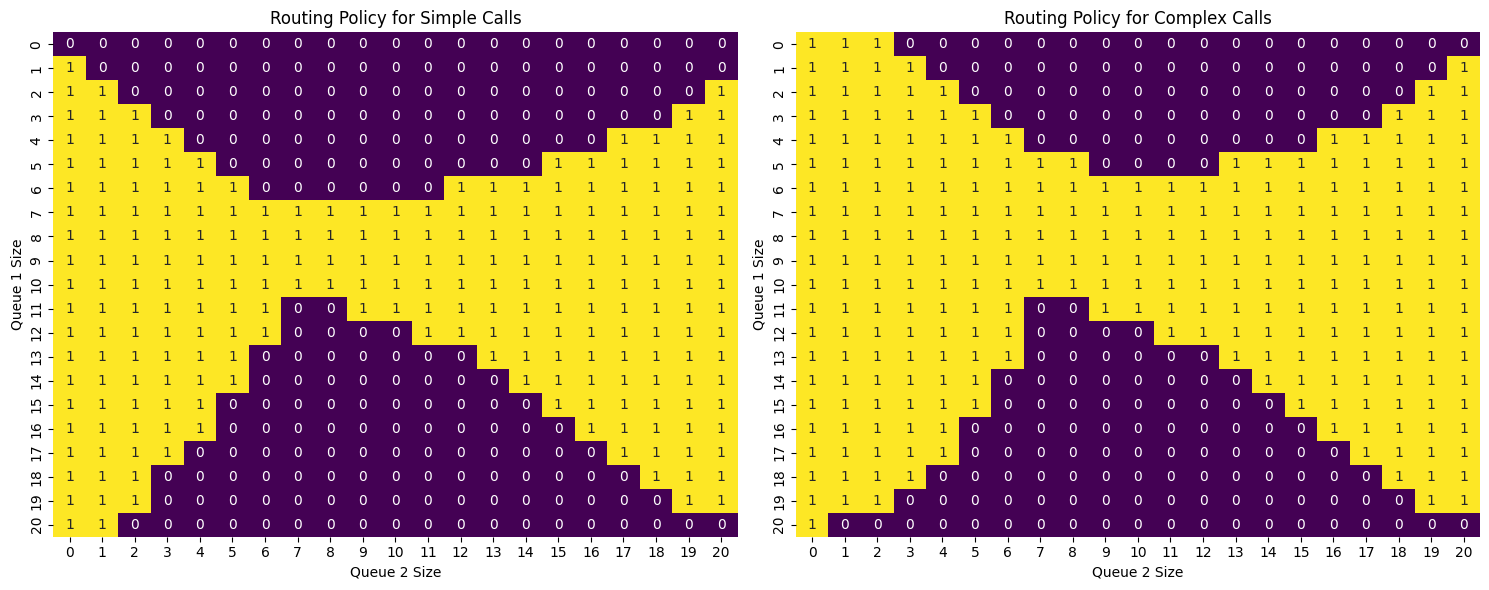


Simulation Results:
Average Waiting Time: 19.56
Rejection Rate: 57.19%
Average Queue Length: 20.82


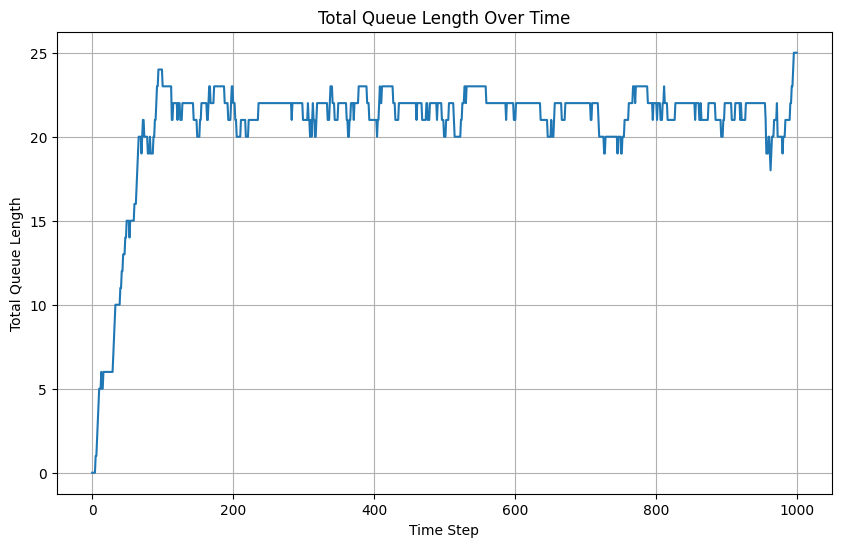

In [21]:
# Simulate the call centre MDP

# Initialise the MDP
mdp = CallCentreMDP(
    arrival_rates=(15/60, 10/60),   # Simple calls arrive more frequently than complex calls
    service_rates=((25/60, 8/60),  # Agent 1 is better at simple calls
                   (20/60, 10/60)),  # Agent 2 is better at complex calls
    max_queue_size=20,
    discount_factor=0.95
)

# Solve the MDP using value iteration
V, policy = mdp.value_iteration(max_iterations=100)

# Save optimal policy to a file
mdp.save_policy("optimal_policy.pkl")

# Extract the optimal policy
optimal_policy = mdp.extract_policy()

# Visualize the policy
mdp.visualize_policy()

# Simulate using the optimal policy
results = mdp.simulate(num_steps=1000)

print("\nSimulation Results:")
print(f"Average Waiting Time: {results['avg_waiting_time']:.2f}")
print(f"Rejection Rate: {results['rejection_rate']:.2%}")
print(f"Average Queue Length: {results['avg_queue_length']:.2f}")

# Plot queue lengths over time
queue_lengths = results['queue_lengths']
total_queue_length = [sum(ql) for ql in queue_lengths]

plt.figure(figsize=(10, 6))
plt.plot(total_queue_length)
plt.title("Total Queue Length Over Time")
plt.xlabel("Time Step")
plt.ylabel("Total Queue Length")
plt.grid(True)
plt.show()